Note: ChatGPT was utilized for coding.

“ChatGPT: State labeling and optimization,” ChatGPT: Array copy issue,” "ChatGPT: Overlay plot with shading,” "K-means++ randomness issue,” "Markov switching forecasting issues,” “ChatGPT: Real-time forecasting with AR." ChatGPT. [Online] Available: 
https://chatgpt.com/share/67c27bc7-9fc0-8005-bb81-8c4bbb17d290, https://chatgpt.com/share/67f176a4-e370-8005-a9f6-6907f2212a13, https://chatgpt.com/share/67f18721-6500-8005-b89d-4c7e05fb6db7, https://chatgpt.com/share/67da1ae1-0544-8005-a569-413cbf705e6c, https://chatgpt.com/share/67f186e6-be48-8005-829b-0cf38c07c1f6, https://chatgpt.com/share/67f08ee9-9390-8005-877d-0d078b4adeab.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# **Read FRED GDP Data**

In [3]:
# Read GDP File
df_gdp = pd.read_csv('rGDP_JS.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

Text(0.5, 1.0, 'US GDP Growth Overtime')

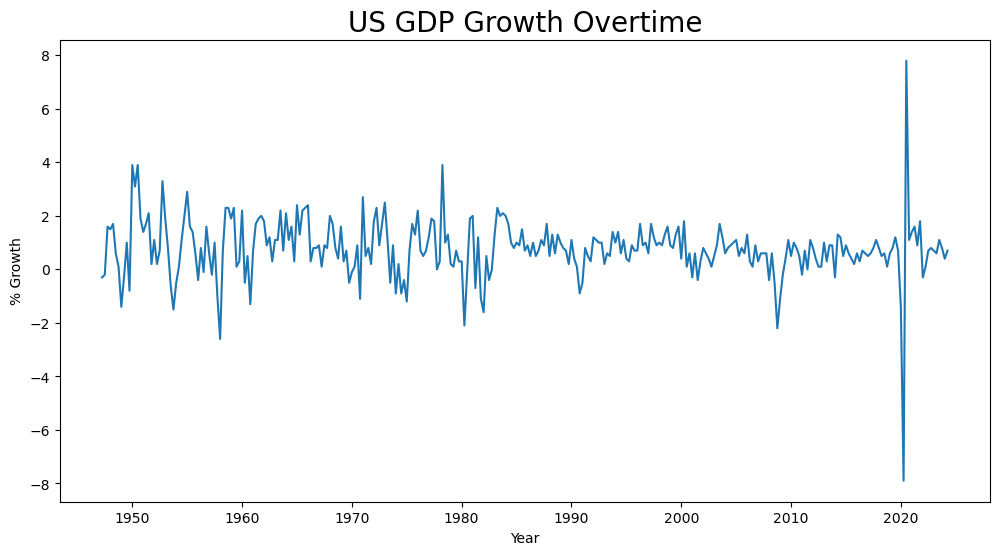

In [4]:
# Plot GDP
plt.figure(figsize=(12, 6))
plt.plot(df_gdp)
plt.xlabel('Year')
plt.ylabel('% Growth')
plt.title('US GDP Growth Overtime', fontsize='20')

# **Step 1: Regime Identification**

## **i. Feature Generation** *(Nystrup, et al. 2020)*

In [5]:
# Select Window Length
w1 = 6
w2 = 14

In [6]:
df_gdp_ft = df_gdp[max(w1, w2) - 1:]

*Absolute Change*

In [7]:
abs_change = []

for i in range(len(df_gdp_ft)):
  absChange = np.abs(df_gdp.rGDP[i + max(w1, w2) - 1] - df_gdp.rGDP[i + max(w1, w2) - 2])
  abs_change.append(absChange)

df_gdp_ft["AbsChange"] = abs_change

/tmp/ipykernel_666509/3168161603.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  absChange = np.abs(df_gdp.rGDP[i + max(w1, w2) - 1] - df_gdp.rGDP[i + max(w1, w2) - 2])
/tmp/ipykernel_666509/3168161603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["AbsChange"] = abs_change


*Previous Absolute Change*

In [8]:
prev_abs_change = []

for i in range(len(df_gdp_ft)):
  prevAbsChange = np.abs(df_gdp.rGDP[i + max(w1, w2) - 2] - df_gdp.rGDP[i + max(w1, w2) - 3])
  prev_abs_change.append(prevAbsChange)

df_gdp_ft["PrevAbs Change"] = prev_abs_change

/tmp/ipykernel_666509/1066985137.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prevAbsChange = np.abs(df_gdp.rGDP[i + max(w1, w2) - 2] - df_gdp.rGDP[i + max(w1, w2) - 3])
/tmp/ipykernel_666509/1066985137.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["PrevAbs Change"] = prev_abs_change


**Features at w = 14**

*Center Component*

In [9]:
centered_mean = []
centered_std = []

for i in range(len(df_gdp_ft)):
  hold = []
  for j in range(w2):
    # Mean and Std from np.abs(df_gdp.rGDP[i + max(w1, w2) - 1 - 14 + 1] to df_gdp.rGDP[i + max(w1, w2) - 1])
    hold.append(df_gdp.rGDP[i + max(w1, w2) - w2 + j])
  centeredMean = np.average(hold)
  centeredStd = np.std(hold)
  centered_mean.append(centeredMean)
  centered_std.append(centeredStd)

df_gdp_ft["CenteredMean(14)"] = centered_mean
df_gdp_ft["CenteredStd(14)"] = centered_std

/tmp/ipykernel_666509/603088380.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hold.append(df_gdp.rGDP[i + max(w1, w2) - w2 + j])
/tmp/ipykernel_666509/603088380.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["CenteredMean(14)"] = centered_mean
/tmp/ipykernel_666509/603088380.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

*Left Component*

In [10]:
left_mean = []
left_std = []

for i in range(len(df_gdp_ft)):
  hold = []
  for j in range(int(w2/2)):
    # Mean from np.abs(df_gdp.rGDP[i + max(w1, w2) - 1 - 14 + 1] to df_gdp.rGDP[i + max(w1, w2) - 1 - 7])
    hold.append(df_gdp.rGDP[i + max(w1, w2) - w2 + j])
  leftMean = np.average(hold)
  leftStd = np.std(hold)
  left_mean.append(leftMean)
  left_std.append(leftStd)

df_gdp_ft["LeftMean(14)"] = left_mean
df_gdp_ft["LeftStd(14)"] = left_std

/tmp/ipykernel_666509/2429308197.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hold.append(df_gdp.rGDP[i + max(w1, w2) - w2 + j])
/tmp/ipykernel_666509/2429308197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["LeftMean(14)"] = left_mean
/tmp/ipykernel_666509/2429308197.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

*Right Component*

In [11]:
right_mean = []
right_std = []

for i in range(len(df_gdp_ft)):
  hold = []
  for j in range(int(w2/2)):
    # Mean from np.abs(df_gdp.rGDP[i + max(w1, w2) - 1 - 7 + 1] to df_gdp.rGDP[i + max(w1, w2) - 1])
    hold.append(df_gdp.rGDP[i + max(w1, w2) - int(w2/2) + j])
  rightMean = np.average(hold)
  rightStd = np.std(hold)
  right_mean.append(rightMean)
  right_std.append(rightStd)

df_gdp_ft["RightMean(14)"] = right_mean
df_gdp_ft["RightStd(14)"] = right_std

/tmp/ipykernel_666509/1295607971.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hold.append(df_gdp.rGDP[i + max(w1, w2) - int(w2/2) + j])
/tmp/ipykernel_666509/1295607971.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["RightMean(14)"] = right_mean
/tmp/ipykernel_666509/1295607971.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

**Features at w = 6**

*Center Component*

In [12]:
centered_mean = []
centered_std = []

for i in range(len(df_gdp_ft)):
  hold = []
  for j in range(w1):
    # Mean and Std from np.abs(df_gdp.rGDP[i + max(w1, w2) - 1 - 6 + 1] to df_gdp.rGDP[i + max(w1, w2) - 1])
    hold.append(df_gdp.rGDP[i + max(w1, w2) - w1 + j])
  centeredMean = np.average(hold)
  centeredStd = np.std(hold)
  centered_mean.append(centeredMean)
  centered_std.append(centeredStd)

df_gdp_ft["CenteredMean(6)"] = centered_mean
df_gdp_ft["CenteredStd(6)"] = centered_std

/tmp/ipykernel_666509/1041938135.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hold.append(df_gdp.rGDP[i + max(w1, w2) - w1 + j])
/tmp/ipykernel_666509/1041938135.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["CenteredMean(6)"] = centered_mean
/tmp/ipykernel_666509/1041938135.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

*Left Component*

In [13]:
left_mean = []
left_std = []

for i in range(len(df_gdp_ft)):
  hold = []
  for j in range(int(w1/2)):
    # Mean from np.abs(df_gdp.rGDP[i + max(w1, w2) - 1 - 6 + 1] to df_gdp.rGDP[i + max(w1, w2) - 1 - 3])
    hold.append(df_gdp.rGDP[i + max(w1, w2) - w1 + j])
  leftMean = np.average(hold)
  leftStd = np.std(hold)
  left_mean.append(leftMean)
  left_std.append(leftStd)

df_gdp_ft["LeftMean(6)"] = left_mean
df_gdp_ft["LeftStd(6)"] = left_std

/tmp/ipykernel_666509/726827072.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hold.append(df_gdp.rGDP[i + max(w1, w2) - w1 + j])
/tmp/ipykernel_666509/726827072.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["LeftMean(6)"] = left_mean
/tmp/ipykernel_666509/726827072.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

*Right Component*

In [14]:
right_mean = []
right_std = []

for i in range(len(df_gdp_ft)):
  hold = []
  for j in range(int(w1/2)):
    # Mean from np.abs(df_gdp.rGDP[i + max(w1, w2) - 1 - 3 + 1] to df_gdp.rGDP[i + max(w1, w2) - 1])
    hold.append(df_gdp.rGDP[i + max(w1, w2) - int(w1/2) + j])
  rightMean = np.average(hold)
  rightStd = np.std(hold)
  right_mean.append(rightMean)
  right_std.append(rightStd)

df_gdp_ft["RightMean(6)"] = right_mean
df_gdp_ft["RightStd(6)"] = right_std

/tmp/ipykernel_666509/3669477337.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hold.append(df_gdp.rGDP[i + max(w1, w2) - int(w1/2) + j])
/tmp/ipykernel_666509/3669477337.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp_ft["RightMean(6)"] = right_mean
/tmp/ipykernel_666509/3669477337.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

**What we have now:** 15-dimensional feature vector for the rGDP return Time Series

In [15]:
df_gdp_ft

,rGDP,AbsChange,PrevAbs Change,CenteredMean(14),CenteredStd(14),LeftMean(14),LeftStd(14),RightMean(14),RightStd(14),CenteredMean(6),CenteredStd(6),LeftMean(6),LeftStd(6),RightMean(6),RightStd(6)
observation_date,,,,,,,,,,,,,,,
1950-07-01,3.9,0.8,0.8,1.028571,1.628070,0.714286,0.813157,1.342857,2.107712,1.800000,1.928730,-0.033333,0.758654,3.633333,0.377124
1950-10-01,1.9,2.0,0.8,1.185714,1.598149,0.557143,1.062150,1.814286,1.786000,2.166667,1.688852,1.366667,1.936205,2.966667,0.821922
1951-01-01,1.4,0.5,2.0,1.300000,1.551497,0.542857,1.072856,2.057143,1.586422,2.233333,1.648905,2.066667,2.053182,2.400000,1.080123
1951-04-01,1.7,0.3,0.5,1.307143,1.553091,0.457143,1.006915,2.157143,1.537955,2.650000,1.029158,3.633333,0.377124,1.666667,0.205480
1951-07-01,2.1,0.4,0.3,1.350000,1.566046,0.128571,0.988092,2.571429,0.972059,2.350000,0.871302,2.966667,0.821922,1.733333,0.286744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01,0.6,0.1,0.1,0.564286,3.077710,0.500000,4.309458,0.628571,0.604068,0.433333,0.398609,0.166667,0.410961,0.700000,0.081650
2023-07-01,1.1,0.5,0.1,0.742857,3.030727,0.957143,4.253018,0.528571,0.436592,0.666667,0.298142,0.533333,0.309121,0.800000,0.216025
2023-10-01,0.8,0.3,0.5,1.364286,1.861108,2.042857,2.434782,0.685714,0.279942,0.783333,0.157233,0.733333,0.047140,0.833333,0.205480


In [16]:
# Determine Training and Testing Period
df_gdp_ft_train = df_gdp_ft [136:220]
df_gdp_ft_test = df_gdp_ft[220-1:-30]

# **Step 2: Regime Fitting Forecast**

CVXPY Citation: https://drive.google.com/file/d/1VyB1QPfnzWfribfMdIJNdSlcbFsUQuqu/view?usp=sharing

K-Means Citation: https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html

Utilizing K-Means++ *(Nystrup, et al. 2020)*

Statistical Jump Model Fitting

In [17]:
def JM (np_gdp_ft, lamda):

  # ---------------- K-Means Initialization ------------------

  kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++', n_init="auto").fit(np_gdp_ft)
  kmeans_labels = kmeans.labels_
  s_hat_hold = kmeans_labels

  # ------------------------------------------------------------

  objectiveValuePrev = 0
  objectiveValueCurrent = 0
  objectiveValueDiff = 100000

  n = 0
  T = np_gdp_ft.shape[0]
  D = df_gdp_ft.shape[1]
  print("Objective Value Convergence per Iteration (lamda = ", lamda, ")")

  while objectiveValueDiff > 10e-6:

    # ----------------- MODEL FITTING COMPONENT ------------------------
    #      (input: a state sequence s_hat_hold and series np_gdp_ft)

    # Declare Variables
    theta0 = cp.Variable(D)
    theta1 = cp.Variable(D)

    # Objective Function
    loss = 0
    for i in range(T):
      if (s_hat_hold[i] == 0):
        loss = (1/2) * cp.sum_squares(np_gdp_ft[i] - theta0) + loss
      if (s_hat_hold[i] == 1):
        loss = (1/2) *  cp.sum_squares(np_gdp_ft[i] - theta1) + loss
    objective = cp.Minimize(loss)

    # Solve Problem
    problem = cp.Problem(objective)
    problem.solve()

    # ----------------- STATE-SEQUENCE FITTING ------------------------
    #      (input: parameter vector theta_0 and theta_1)

    # Populate Loss Matrix L
    K = 2 # Number of States
    L = np.zeros((T,K))
    for i in range(T):
        L[i][0] = (1/2) * np.linalg.norm(np_gdp_ft[i] - theta0.value)**2
        L[i][1] = (1/2) * np.linalg.norm(np_gdp_ft[i] - theta1.value)**2

    # Begin Dynamic Programming
    V = np.zeros((T,K)) # starting from t=1, not t=0
    V[0][0] = L[0][0] # Initialization
    V[0][1] = L[0][1] # Initialization

    # Populate V Matrix for k = 0,1
    for i in range(T - 1):
      V[i + 1][0] = L[i + 1][0] + min(V[i][0], V[i][1] + lamda)
      V[i + 1][1] = L[i + 1][1] + min(V[i][0] + lamda, V[i][1])

    # Compute Optimal Value and Optimal Final State
    objectiveValue = min(V[T-1][0], V[T-1][1])
    s_hat = np.zeros(T)
    s_hat[T-1] = np.argmin([V[T-1][0], V[T-1][1]])

    # Retrace State Sequence s_hat from Optimal Value
    for i in range(T-1):
        if (s_hat[T-1-i] == 0):
            s_hat[T-2-i] = np.argmin([V[T-2-i][0],V[T-2-i][1] + lamda])
        if (s_hat[T-1-i] == 1):
            s_hat[T-2-i] = np.argmin([V[T-2-i][0] + lamda,V[T-2-i][1]])

    # Calculating Convergence Improvement per Iteration
    if (n == 0):
      objectiveValuePrev = objectiveValue
    if (n > 0):
      objectiveValueCurrent = objectiveValue
      objectiveValueDiff = np.abs(objectiveValuePrev - objectiveValueCurrent)
      objectiveValuePrev = objectiveValueCurrent

    n = n + 1
    print(objectiveValueDiff)

    s_hat_hold = s_hat

  # ----------------- DEFINE RECESSIONARY REGIME ------------------------

  # Define s_t = 1 as the recessionary regime
  if (theta1.value[0] > theta0.value[0]):
      for i in range(len(s_hat_hold)):
          if (s_hat_hold[i] == 0):
              s_hat_hold[i] = 1
          else:
              s_hat_hold[i] = 0
      theta0_value = theta1.value.copy()
      theta1_value = theta0.value.copy()
    
  else:
      theta0_value = theta0.value.copy()
      theta1_value = theta1.value.copy()

  print('Total Iterations: ', n)
  return theta0_value, theta1_value, s_hat_hold

Same as above, but with no print statements

In [18]:
def JMNoPrint (np_gdp_ft, lamda):

  # ---------------- K-Means Initialization ------------------

  kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++', n_init="auto").fit(np_gdp_ft)
  kmeans_labels = kmeans.labels_
  s_hat_hold = kmeans_labels

  # ------------------------------------------------------------

  objectiveValuePrev = 0
  objectiveValueCurrent = 0
  objectiveValueDiff = 100000

  n = 0
  T = np_gdp_ft.shape[0]
  D = df_gdp_ft.shape[1]

  while objectiveValueDiff > 10e-6:

    # ----------------- MODEL FITTING COMPONENT ------------------------
    #      (input: a state sequence s_hat_hold and series np_gdp_ft)

    # Declare Variables
    theta0 = cp.Variable(D)
    theta1 = cp.Variable(D)

    # Objective Function
    loss = 0
    for i in range(T):
      if (s_hat_hold[i] == 0):
        loss = (1/2) * cp.sum_squares(np_gdp_ft[i] - theta0) + loss
      if (s_hat_hold[i] == 1):
        loss = (1/2) *  cp.sum_squares(np_gdp_ft[i] - theta1) + loss
    objective = cp.Minimize(loss)

    # Solve Problem
    problem = cp.Problem(objective)
    problem.solve()

    # ----------------- STATE-SEQUENCE FITTING ------------------------
    #      (input: parameter vector theta_0 and theta_1)

    # Populate Loss Matrix L
    K = 2 # Number of States
    L = np.zeros((T,K))
    for i in range(T):
        L[i][0] = (1/2) * np.linalg.norm(np_gdp_ft[i] - theta0.value)**2
        L[i][1] = (1/2) * np.linalg.norm(np_gdp_ft[i] - theta1.value)**2

    # Begin Dynamic Programming
    V = np.zeros((T,K)) # starting from t=1, not t=0
    V[0][0] = L[0][0] # Initialization
    V[0][1] = L[0][1] # Initialization

    # Populate V Matrix for k = 0,1
    for i in range(T - 1):
      V[i + 1][0] = L[i + 1][0] + min(V[i][0], V[i][1] + lamda)
      V[i + 1][1] = L[i + 1][1] + min(V[i][0] + lamda, V[i][1])

    # Compute Optimal Value and Optimal Final State
    objectiveValue = min(V[T-1][0], V[T-1][1])
    s_hat = np.zeros(T)
    s_hat[T-1] = np.argmin([V[T-1][0], V[T-1][1]])

    # Retrace State Sequence s_hat from Optimal Value
    for i in range(T-1):
        if (s_hat[T-1-i] == 0):
            s_hat[T-2-i] = np.argmin([V[T-2-i][0],V[T-2-i][1] + lamda])
        if (s_hat[T-1-i] == 1):
            s_hat[T-2-i] = np.argmin([V[T-2-i][0] + lamda,V[T-2-i][1]])

    # Calculating Convergence Improvement per Iteration
    if (n == 0):
      objectiveValuePrev = objectiveValue
    if (n > 0):
      objectiveValueCurrent = objectiveValue
      objectiveValueDiff = np.abs(objectiveValuePrev - objectiveValueCurrent)
      objectiveValuePrev = objectiveValueCurrent

    n = n + 1

    s_hat_hold = s_hat

  # ----------------- DEFINE RECESSIONARY REGIME ------------------------

  # Define s_t = 1 as the recessionary regime
  if (theta1.value[0] > theta0.value[0]):
      for i in range(len(s_hat_hold)):
          if (s_hat_hold[i] == 0):
              s_hat_hold[i] = 1
          else:
              s_hat_hold[i] = 0
      theta0_value = theta1.value.copy()
      theta1_value = theta0.value.copy()
    
  else:
      theta0_value = theta0.value.copy()
      theta1_value = theta1.value.copy()

  return theta0_value, theta1_value, s_hat_hold

Forecasting

In [19]:
# -------------------- PARAMETER CONTROLS ------------------------
n = 1 # Number of Quarters until Refit and Re-train
m = 1000000 # Number of Quarters until Hyperparameter is Tuned
hyperpar_testperiod = 4 # Number of Quarters to Test and Fine Tune Penalty Term
lamda_set = np.logspace(-20,2,5,base=np.sqrt(2))

Hyperparamater Tuning In Progress..
Running trial on lamda =  0.0009765624999999987
Running trial on lamda =  0.0065695032441696385
Running trial on lamda =  0.044194173824159196
Running trial on lamda =  0.2973017787506802
Running trial on lamda =  2.0000000000000004
Hyperparamater Tuning Completed. Selected Lamda =  0.044194173824159196

Actual Test:  1
Objective Value Convergence per Iteration (lamda =  0.044194173824159196 )
100000
0.0
Total Iterations:  2

Actual Test:  2
Objective Value Convergence per Iteration (lamda =  0.044194173824159196 )
100000
0.0
Total Iterations:  2

Actual Test:  3
Objective Value Convergence per Iteration (lamda =  0.044194173824159196 )
100000
0.1816473176499258
0.03456011420632876
0.0
Total Iterations:  4

Actual Test:  4
Objective Value Convergence per Iteration (lamda =  0.044194173824159196 )
100000
0.18482841430203933
0.03442057573447954
0.0
Total Iterations:  4

Actual Test:  5
Objective Value Convergence per Iteration (lamda =  0.0441941738241

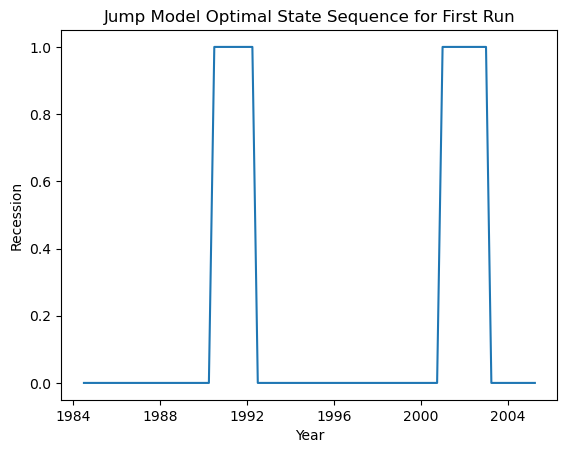

In [20]:
# ------------------ DATA AND VARIABLE PREP ----------------------

# Prepare Dataset to Fit Model
np_gdp_ft = df_gdp_ft_train.to_numpy()
T = np_gdp_ft.shape[0]
D = df_gdp_ft.shape[1]

# Prepare Dataset to Retrain JM
np_gdp_ft_retrain = df_gdp_ft_train.to_numpy()

# Prepare Dataset for Out-of-Sample Testing
data_test_x = df_gdp_ft_test.to_numpy() ## State Prediction
preds = np.zeros(len(data_test_x)-1) ## x_t(1) Prediction

# Store State Predictions
sPreds = np.zeros(len(data_test_x)-1)

count = 1

for i in range(len(data_test_x)-1):

  # ----- OPTIMIZING FOR PENALTY TERM (Yizhan Shu, et al.) ------

  if (i%m == 0):
    print("Hyperparamater Tuning In Progress..")
    norm_error = np.zeros(len(lamda_set))
    preds_hyper = np.zeros((len(lamda_set),hyperpar_testperiod)) # Store GDP Hyperparameter Predictions
    sPreds_hyper = np.zeros(hyperpar_testperiod) # Store Hyperparameter Predictions

    for k in range(len(lamda_set)):

      print("Running trial on lamda = ",lamda_set[k])

      for j in range(hyperpar_testperiod):

        theta0, theta1, s_new = JMNoPrint(np_gdp_ft[:-hyperpar_testperiod+j], lamda_set[k])

        # Preparing Dataset to Train (Retrain every period; np_gdp_ft and s_new updates)
        data_train_x = np_gdp_ft[:-1-hyperpar_testperiod+j]
        data_train_s_t1 = s_new[1:]

        # Train with XGBClassifier
        bst = XGBClassifier()
        bst.fit(data_train_x, data_train_s_t1)

        # Forecasting and Quantifying Norm Error
        sPred_hyper = bst.predict([np_gdp_ft[-hyperpar_testperiod+j]])
        sPreds_hyper[j] = sPred_hyper[0]

        if (sPred_hyper[0] == 0):
          preds_hyper[k][j] = theta0[0]

        if (sPred_hyper[0] == 1):
          preds_hyper[k][j] = theta1[0]

      # Calculate performance and send to norm_error
      norm_error[k] = np.linalg.norm(preds_hyper[k] - np_gdp_ft[:,0][-hyperpar_testperiod:])

    lamda = lamda_set[np.argmin(norm_error)]
    # lamda = 0.001

    print("Hyperparamater Tuning Completed. Selected Lamda = ", lamda)
    print()

  # -------- RE-FITTING JM MODEL (Yizhan Shu, et al.) -----------

  print("Actual Test: ", count)

  if (i%n == 0):
    theta0, theta1, s_new = JM(np_gdp_ft, lamda)
    print()

    if (i == 0):
      plt.plot(df_gdp_ft_train.index,s_new)
      plt.xlabel('Year')
      plt.ylabel('Recession')
      plt.title('Jump Model Optimal State Sequence for First Run')

  # ---------------- TRAINING PHASE {(x_t, s_t+1)} ----------------

  # Preparing Dataset to Train (Retrain every period; np_gdp_ft and s_new updates)
  data_train_x = np_gdp_ft[:-1]
  data_train_s_t1 = s_new[1:]

  # Train with XGBClassifier
  bst = XGBClassifier()
  bst.fit(data_train_x, data_train_s_t1)

  # ---------------------- FORECASTING PHASE ----------------------

  sPred = bst.predict([data_test_x[i]])
  sPreds[i] = sPred[0]

  if (sPred[0] == 0):
    preds[i] = theta0[0]

  if (sPred[0] == 1):
    preds[i] = theta1[0]

  # -------------------- PREPARE FOR NEXT ITERATION ---------------------
  np_gdp_ft_retrain = np.vstack((np_gdp_ft_retrain, data_test_x[i]))
  np_gdp_ft = np_gdp_ft_retrain
  count = count + 1

Text(0.5, 0, 'Years')

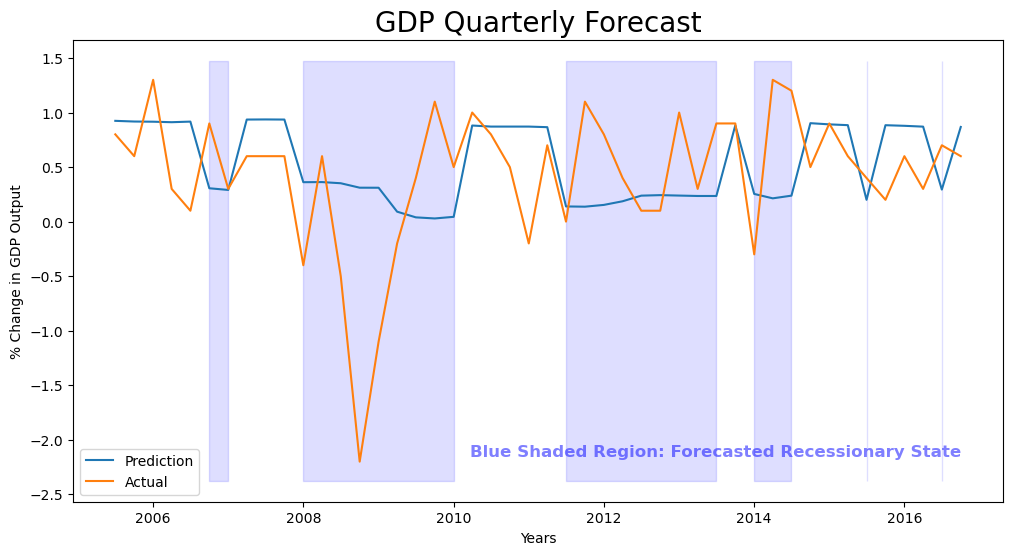

In [21]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title('GDP Quarterly Forecast',fontsize='20')
plt.plot(df_gdp_ft_test[1:].index, preds[:])
plt.plot(df_gdp_ft_test[1:].index, data_test_x[1:,0])
y_min, y_max = plt.ylim()
plt.fill_between(df_gdp_ft_test[1:].index, 
                 y_min, y_max,
                 where=sPreds == 1, 
                 color='blue', alpha=0.13)
plt.text(df_gdp_ft_test[1:].index[-1],
         y_min + (y_max - y_min) * 0.05,
         'Blue Shaded Region: Forecasted Recessionary State',
         color='blue', 
         ha='right',
         va='bottom', 
         fontsize=12, 
         fontweight='bold', 
         alpha=0.5)
plt.legend(('Prediction', 'Actual'))
plt.ylabel('% Change in GDP Output')
plt.xlabel('Years')

In [22]:
print('2-Norm Error: ', np.linalg.norm(preds - data_test_x[1:,0]))

2-Norm Error:  4.564568958655368
